In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
from data_util import load_data

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
(x_train_all, y_train_all), (x_test, y_test) = load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)


### 使用深度可分离卷积神经网络，keras中提供了实现类：SeparableConv2D

激活函数使用'relu'的时候，很难训练模型收敛，换用'selu'激活函数可以保证较快的收敛

In [4]:
model = keras.models.Sequential()
# 在输入层仍旧是使用普通的卷积网络
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='selu',
                              input_shape=(28, 28, 1)))
model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.SeparableConv2D(filters=64, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.SeparableConv2D(filters=64, kernel_size=3,
                                       padding='same',
                                       activation='selu'))

model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.SeparableConv2D(filters=128, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.SeparableConv2D(filters=128, kernel_size=3,
                                       padding='same',
                                       activation='selu'))

model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='selu'))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 14, 14, 64)        2400      
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 14, 14, 64)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 7, 7, 128)         8

#### 参数数量  
全连接层参数数量：(1152+1)*128 = 147584  

In [6]:
logdir = './separable-cnn-relu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3),
]

history = model.fit(x_train_scaled, y_train, epochs=10,
                   validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Epoch 1/10
1719/1719 [==============================] - 13s 8ms/step - loss: 2.3028 - accuracy: 0.1027 - val_loss: 2.3023 - val_accuracy: 0.0976
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 2.3013 - accuracy: 0.1086 - val_loss: 2.2973 - val_accuracy: 0.1012
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 1.5167 - accuracy: 0.4635 - val_loss: 0.7947 - val_accuracy: 0.6778
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7160 - accuracy: 0.7324 - val_loss: 0.6965 - val_accuracy: 0.7150
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6054 - accuracy: 0.7749 - val_loss: 0.5846 - val_accuracy: 0.7792
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5445 - accuracy: 0.7969 - val_loss: 0.5478 - val_accuracy: 0.8030
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4974 - accuracy: 0.8138 - val_loss: 0.4727 - val_ac

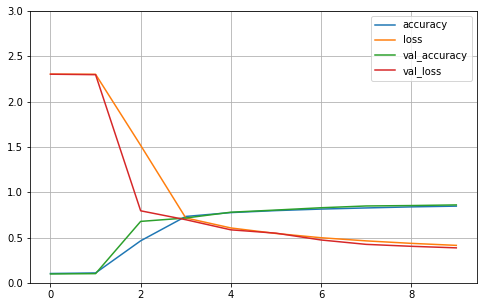

In [7]:
def plot_learning_curve(historyry):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()
    
plot_learning_curve(history)

In [8]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4221 - accuracy: 0.8487


[0.42212095856666565, 0.8486999869346619]